In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import keras 
from keras.models import Sequential, load_model
from keras.layers import *

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

2025-08-31 00:18:29.361027: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 00:18:29.374771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756592309.389326  247489 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756592309.394478  247489 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756592309.407617  247489 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Датасет: https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021

#### Содержит данные о акциях компании Apple в период с 1980 по 2021 год.
#### Целевое значение: High - самая высокая цена, по которой акции торговались в течение определенного периода. Задача регрессии.

In [2]:
import kagglehub
meetnagadia_apple_stock_price_from_19802021_path = kagglehub.dataset_download('meetnagadia/apple-stock-price-from-19802021')

print('Data source import complete.', meetnagadia_apple_stock_price_from_19802021_path)

Data source import complete. /home/michael/.cache/kagglehub/datasets/meetnagadia/apple-stock-price-from-19802021/versions/3


In [3]:
df = pd.read_csv(meetnagadia_apple_stock_price_from_19802021_path + '/AAPL.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
print(len(df))

10468


In [6]:
print(df.head())

print(df.tail())

        Date      Open      High       Low     Close  Adj Close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600
            Date        Open        High         Low       Close   Adj Close  \
10463 2022-06-13  132.869995  135.199997  131.440002  131.880005  131.880005   
10464 2022-06-14  133.130005  133.889999  131.479996  132.759995  132.759995   
10465 2022-06-15  134.289993  137.339996  132.160004  135.429993  135.429993   
10466 2022-06-16  132.080002  132.389999  129.039993  130.059998  130.059998   
10467 2022-06-17  130.070007  133.080002  129.809998  131.559998  131.559998   

          Volume  
10463  122207100  
10464   84784300  
10465   9153

In [7]:
df.info()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,10468,10468.000000,10468.000000,10468.000000,10468.000000,10468.000000,1.046800e+04
mean,2001-09-07 05:59:43.492548608,14.757987,14.921491,14.594484,14.763533,14.130431,3.308489e+08
min,1980-12-12 00:00:00,0.049665,0.049665,0.049107,0.049107,0.038329,0.000000e+00
25%,1991-04-21 06:00:00,0.283482,0.289286,0.276786,0.283482,0.235462,1.237768e+08
50%,2001-08-28 12:00:00,0.474107,0.482768,0.465960,0.475446,0.392373,2.181592e+08
75%,2012-01-25 06:00:00,14.953303,15.057143,14.692589,14.901964,12.835269,4.105794e+08
max,2022-06-17 00:00:00,182.630005,182.940002,179.119995,182.009995,181.511703,7.421641e+09
std,NaN,31.914174,32.289158,31.543959,31.929489,31.637275,3.388418e+08


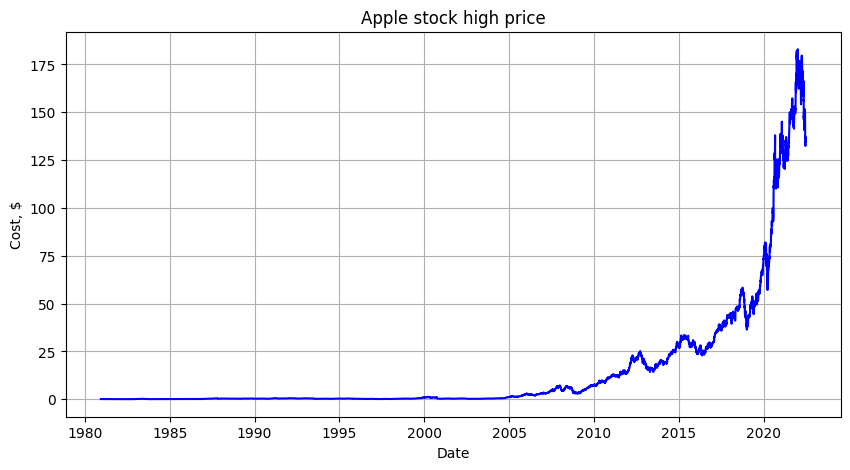

In [9]:
fig = plt.figure(figsize=(10,5))

plt.plot(df['Date'], df['High'], color='blue')
plt.ylabel('Cost, $')
plt.xlabel('Date')
plt.title('Apple stock high price')
plt.grid()
plt.show()

### Предобработка данных

#### По графику видно, что цена акций изменялась не сильно в период с 1980 по 2005 год. Наиболее значимые изменения видны с 2010 по 2021 год, поэтому далее будут рассмотрены данные за этот период.

In [10]:
df = df.loc[(df['Date'] >= '01-01-2010')]

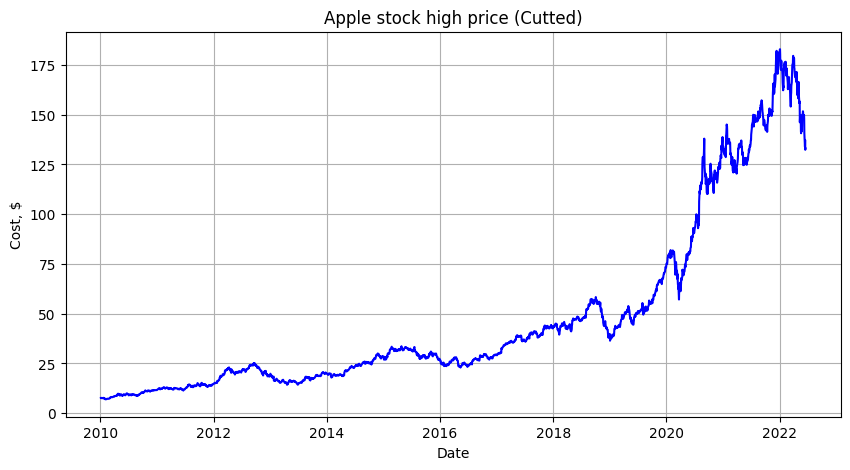

In [11]:
fig = plt.figure(figsize=(10,5))

plt.plot(df['Date'], df['High'], color='blue')
plt.ylabel('Cost, $')
plt.xlabel('Date')
plt.title('Apple stock high price (Cutted)')
plt.grid()
plt.show()

#### Масштабирование при помощи RobustScaler.

In [12]:
scaler = RobustScaler()

df['High'] = scaler.fit_transform(df['High'].values.reshape(-1, 1))

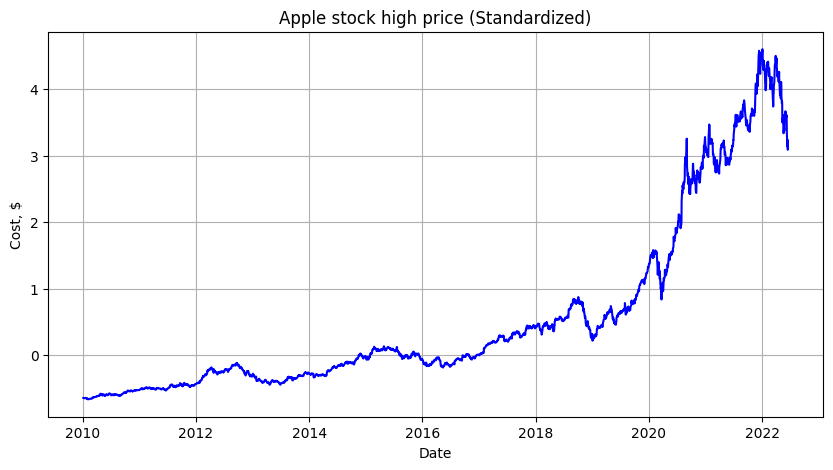

In [13]:
fig = plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['High'], color='blue')
plt.ylabel('Cost, $')
plt.xlabel('Date')
plt.title('Apple stock high price (Standardized)')
plt.grid()
plt.show()

#### Разделение данных на тренировочную и тестовую выборку.

In [14]:
split_value = 0.2
splitter = len(df) - int(len(df) * split_value)
train_df = df.iloc[:splitter]
test_df = df.iloc[splitter:]

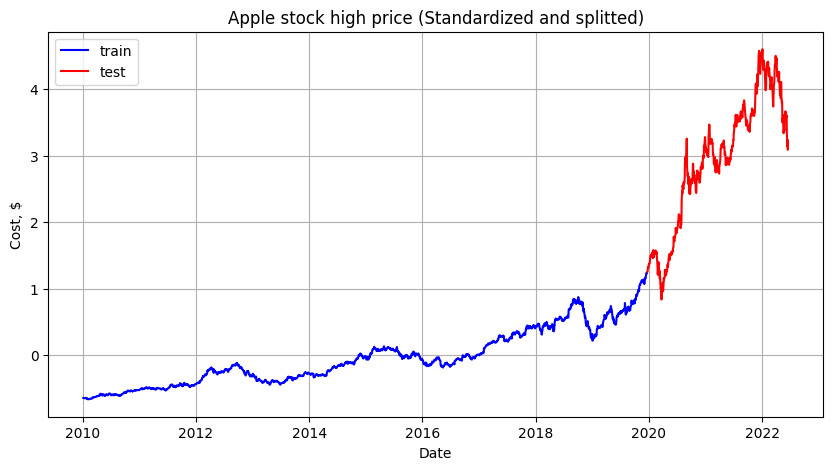

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_df['Date'], train_df['High'], color='blue', label='train')
plt.plot(test_df['Date'], test_df['High'], color='red', label='test')
plt.ylabel('Cost, $')
plt.xlabel('Date')
plt.title('Apple stock high price (Standardized and splitted)')
plt.legend()
plt.grid()
plt.show()

In [16]:
train_data = train_df['High'].values
test_data = test_df['High'].values

#### Создание последовательностей данных длиной в 30 дней (месяц)

In [17]:
sequence_length = 30

In [18]:
n = len(train_data) - sequence_length
X = np.array([train_data[i:i+sequence_length] for i in range(n)])
y = np.array(train_data[sequence_length:sequence_length+n])

#### Разделение тренировочной выборки на непосредственно тренировочную и валидационную части.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Нейросеть
#### Ошибка: mse
#### Были использованы дополнительные метрики: rmse и r2_score, помимо mae.
#### Применены слои двунаправленной LSTM (Bidirectional) и Conv1D, которые обычно показывают хорошие результаты при работе с финансовыми данными.
#### Использованы методы: сохранение лучшей модели, ранняя остановка обучения и динамическая скорость обучения.

In [20]:
r2_score = keras.metrics.R2Score(
    class_aggregation="uniform_average", num_regressors=0, name="r2_score", dtype=None
)

rmae = keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)

I0000 00:00:1756592312.420192  247489 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [31]:
model = Sequential([
    Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Bidirectional(LSTM(512, return_sequences=True)),
    Dropout(0.3),

    LSTM(256),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', rmae, r2_score])

print(model.summary())

/home/michael/ai_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 512)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 14, 1024)       │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,545,217 (21.15 MB)

 Trainable params: 5,545,217 (21.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
checkpoint_path = "./best-model.keras"

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

### Обучение и результаты.

In [33]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/100
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1238 - mae: 0.2794 - r2_score: 0.6056 - root_mean_squared_error: 0.2612
Epoch 1: val_loss improved from inf to 0.02014, saving model to ./best-model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.1138 - mae: 0.2629 - r2_score: 0.6207 - root_mean_squared_error: 0.2559 - val_loss: 0.0201 - val_mae: 0.1253 - val_r2_score: 0.8787 - val_root_mean_squared_error: 0.1419 - learning_rate: 1.0000e-04
Epoch 2/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0135 - mae: 0.0922 - r2_score: 0.9229 - root_mean_squared_error: 0.1149
Epoch 2: val_loss improved from 0.02014 to 0.00387, saving model to ./best-model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0130 - mae: 0.0901 - r2_score: 0.9256 - root_mean_squared_error: 0.1128 - val_loss: 0.0039 - val_mae: 0.0493 - val_r2_score: 0.9767 - val_root_mean_squared_error: 0.0622 - learning_rate: 1.0000e-04
Epoch 3/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0053

In [34]:
def show_train_results(history):
    history_dict = history.history
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics = ['mae', 'root_mean_squared_error', 'r2_score']
    metric_names = ['MAE', 'RMSE', 'R² Score']
    y_labels = ['MAE Value', 'RMSE Value', 'R² Score']
    
    for i, (metric, name, ylabel) in enumerate(zip(metrics, metric_names, y_labels)):
        train_values = history_dict.get(metric, [])
        val_values = history_dict.get(f'val_{metric}', [])
        
        epochs = range(1, len(train_values) + 1)
        
        axes[i].plot(epochs, train_values, 'b-', label=f'Train {name}')
        axes[i].plot(epochs, val_values, 'r-', label=f'Validation {name}')
        axes[i].set_title(f'{name} during Training')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nФинальные значения метрик:")
    for metric in metrics:
        train_final = history_dict[metric][-1] if metric in history_dict else 'N/A'
        val_final = history_dict.get(f'val_{metric}', ['N/A'])[-1]
        print(f"{metric}: Train = {train_final:.4f}, Validation = {val_final:.4f}")

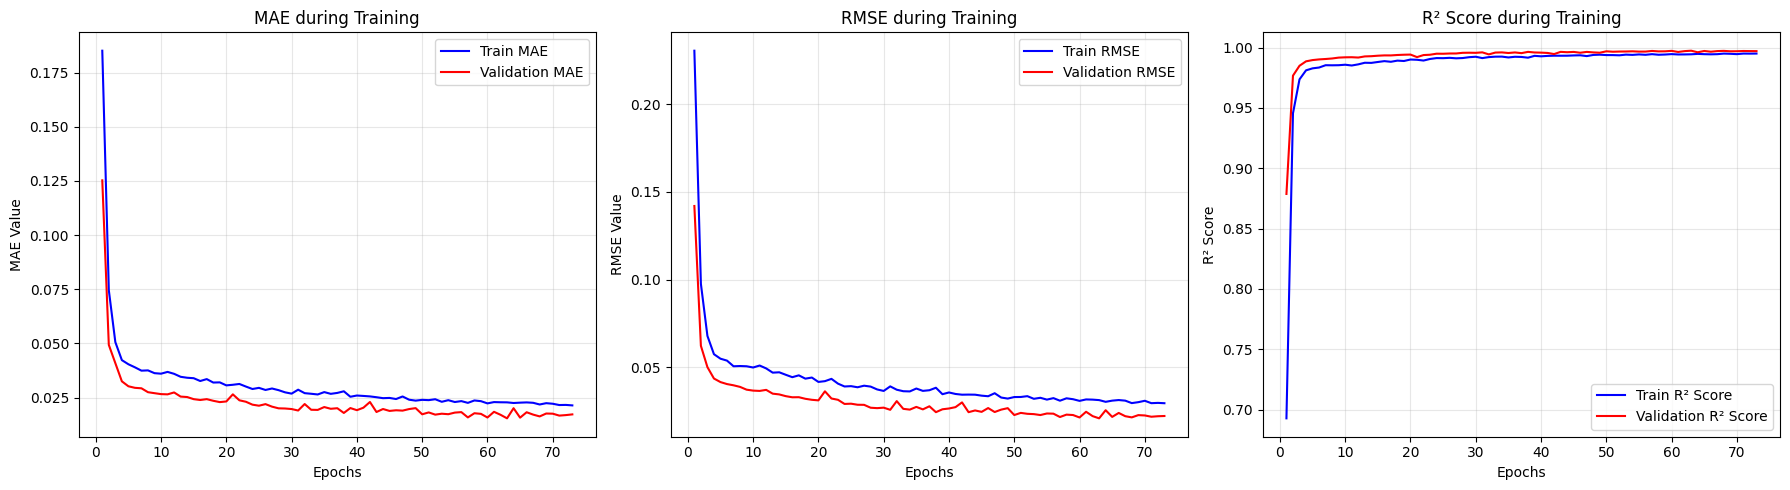


Финальные значения метрик:
mae: Train = 0.0214, Validation = 0.0172
root_mean_squared_error: Train = 0.0295, Validation = 0.0222
r2_score: Train = 0.9950, Validation = 0.9970


In [35]:
show_train_results(history)

### Загрузка лучшей модели и её тестирование

In [36]:
best_model = load_model(checkpoint_path)

In [37]:
n = len(test_data) - sequence_length
X_val = np.array([test_data[i:i+sequence_length] for i in range(n)])
y_val = np.array(test_data[sequence_length:sequence_length+n])

#### Обратное преобразование целевого значения после масштабирования.

In [38]:
pred = best_model.predict(X_val)
pred = scaler.inverse_transform(pred).reshape(-1, 1)
target = scaler.inverse_transform(y_val.reshape(-1, 1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


#### Визуализация предсказания модели и целевого значения.

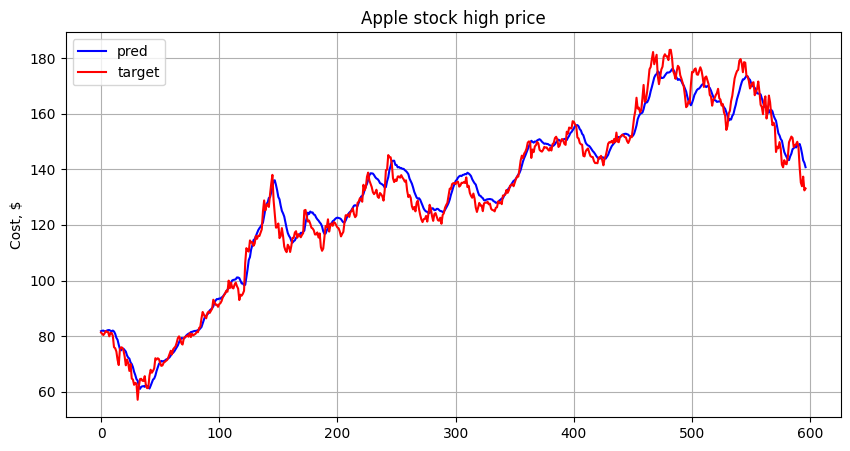

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(pred, color='blue', label='pred')
plt.plot(target, color='red', label='target')
plt.ylabel('Cost, $')
plt.title('Apple stock high price')
plt.legend()
plt.grid()
plt.show()

In [40]:
mae_value = mean_absolute_error(pred, target)
map_value = mean_absolute_percentage_error(target, pred) * 100

print(f'Validation MAE: {mae_value:.6f}')
print(f'Mean Absolute Percentage Error (MAPE): {map_value:.2f}%')

Validation MAE: 3.173342
Mean Absolute Percentage Error (MAPE): 2.51%


### Выводы

#### Удалось успешно спроектировать модель реккурентной нейронной сети и обучить её на последовательностях данных, представленных акциями компании Apple.
#### Лучший результат: средняя абсолютная ошибка: 3.173342 $, среднее абсолютное отклонение: 2.51%. Визуально модель также справилась хорошо, последовательности близки друг к другу.